In [1]:
import rpy2.robjects as robjects
import argparse
import os
import json
import warnings
import pandas as pd
import numpy as np
import time
import random
import collections
import copy

import torch

from op_main import OperatorNetInit
from train import train

warnings.filterwarnings(action='ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [4]:
print("#"*20," FIR-DKT START ", "#"*20)

num_partial_kc = 12
num_candidate_kc = 10
num_total_kc = 20
num_logs = 1000
target_err = 0.05

####################  FIR-DKT START  ####################


In [5]:
# 전체 세트에서 첫번째 subset 반환
def SelPartialKCs(json_path, data_path):
    sub_kcs = np.zeros(num_partial_kc)
    
    #json_path = './info_back.json'
    # 기존 json 파일 읽어오기
    with open(json_path, 'r') as file:
        data = json.load(file)

    # 데이터 수정
    data[0]['input_file_name'] = str(data_path)

    # 기존 json 파일 덮어쓰기
    with open(json_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent="\t", ensure_ascii=False)

    # R 관계 분석 실행
    robjects.r.source('./20220731_RF_LASSO.R', encoding='utf-8')
    
    # 결과 파일 가져와서 정제하기
    subset_df = pd.read_csv('./OUT/relation.csv')
    
    all_kcs = list(subset_df['before'].unique())
    
    
    # sub_kcs 는 첫번째 원소는 before, 그 뒤는 모두 rank 순으로 after임.
    sub_kcs = {}
    for i in range(len(all_kcs)):
        cond = subset_df['before'] == all_kcs[0]
        after_kcs = list(subset_df[cond]['after'])

        sub_kcs[all_kcs[i]] = after_kcs
    
    
    # 후보로 뽑힌 12개 KC 반환
    return all_kcs, sub_kcs

In [6]:
def DoOperatorNet(data_path, n_epochs, kc_candidates, target_KC):
    # operator net을 위한 init
    model, n_epochs,train_loader,device,optimizer,valid_loader,n_items, items,acc_history, auc_history,f1_score_history = OperatorNetInit(data_path, n_epochs, kc_candidates, target_KC)

    print("="*20 + "TRAIN START" + "="*20)
    train(model, n_epochs,train_loader,device,optimizer,valid_loader,n_items,acc_history, auc_history,f1_score_history)
    print("="*20 + "TRAIN END" + "="*20)
    
    influence_mat = model.influence_matrix()
    influence_sum = []
    for i in range(n_items-1):
        influence_sum.append(sum(influence_mat[i]))
    
    rank = sorted(range(len(influence_sum)), key=lambda k: influence_sum[k], reverse=True)
    
#    print("Rank of KCs:")
#    print(items[rank])
#    for i in range(10):
#        print(items[rank.index(i)])

#    print(f1_score_history,auc_history, acc_history)
    
    ranked_kc_rel = items[rank]
    cur_err = max(auc_history)

    return ranked_kc_rel, cur_err

In [7]:
def SelectKCSet(KC_picking_tb, KC_candidates):
    pick_n = 5 - len(KC_candidates)
    m = pick_n - 1
    
    KC_picking_tb = dict(sorted(KC_picking_tb.items(), key=lambda x:x[1], reverse=False))
#    print("low : ", KC_picking_tb)
    low_set = []
    for key, value in KC_picking_tb.items():
        if key not in KC_candidates:
            low_set.append(key)
        if len(low_set) >= 3:
            break
    pick1 = random.sample(low_set, 1)
    KC_candidates.extend(pick1)
    
    KC_picking_tb = dict(sorted(KC_picking_tb.items(), key=lambda x:x[1], reverse=True))
#    print("high : ", KC_picking_tb)
    high_set = []
    for key, value in KC_picking_tb.items():
        if key not in KC_candidates:
            high_set.append(key)
        if len(high_set) >= 4:
            break
    pick2 = random.sample(high_set, m)
    KC_candidates.extend(pick2)
    
    # picking table update
    picks = pick1+pick2
    print("pick1 : ", pick1)
    print("pick2 : ", pick2)
    for i in range(len(picks)):
        KC_picking_tb[picks[i]] += 1 
    print("4 KC_picking_tb +++++ : ", KC_picking_tb)

    return KC_candidates, KC_picking_tb

In [8]:
seed = 42
json_path = './info_back.json'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
data_path = "./data/select_test.csv"
n_epochs = 100

In [9]:
#GetRankedKCGraph(json_path, data_path)

In [10]:
# 결과 파일 가져와서 정제하기
subset_df = pd.read_csv('./OUT/select_test.csv')

all_kcs = list(subset_df['before'].unique())


# sub_kcs 는 첫번째 원소는 before, 그 뒤는 모두 rank 순으로 after임.
sub_kcs = {}
for i in range(len(all_kcs)):
    cond = subset_df['before'] == all_kcs[i]
    after_kcs = list(subset_df[cond]['after'])

    sub_kcs[all_kcs[i]] = after_kcs

In [11]:
#result_df = pd.DataFrame(index=range(0), columns=['target','rel1','rel2','rel3','rel4','rel5','rel6','rel7','rel8','rel9','rel10','auc'])
result_df = pd.DataFrame(index=range(0), columns=['target','rel1','rel2','rel3','rel4','rel5','auc'])
result_df

,target,rel1,rel2,rel3,rel4,rel5,auc


In [19]:
result_df = pd.DataFrame(index=range(0), columns=['target','rel1','rel2','rel3','rel4','rel5','auc'])

#for kc_idx in range(num_total_kc):
for kc_idx in range(1):
    KC_picking_tb = dict(zip(sub_kcs[all_kcs[kc_idx]], [0]*12))
    print("KC_picking_tb : ", KC_picking_tb)

    cnt_best_kcs = 0
    best_auc = 0
    cur_err = 0
    best_kcs = []
    kc_candidates = random.sample(sub_kcs[all_kcs[kc_idx]], 5)
    new_kcs = []
    
    # operator net(train)
    ranked_kc_rel, cur_err = DoOperatorNet(data_path, n_epochs, kc_candidates, all_kcs[kc_idx])

    result_list = []
    result_list.append(all_kcs[kc_idx])
    result_list.extend(ranked_kc_rel)
    result_list.append(cur_err)
    result_df = result_df.append(pd.Series(result_list, index=result_df.columns), ignore_index=True)
    
    before_kcs = copy.deepcopy(ranked_kc_rel)
    best_kcs = copy.deepcopy(ranked_kc_rel)
    best_auc = copy.deepcopy(cur_err)

    print("처음 : ", ranked_kc_rel)

    kc_candidates = random.sample(sub_kcs[all_kcs[kc_idx]], 5)
    print("다음 턴에 들어갈 KC KC: ", kc_candidates)
    
    # picking table update
    for i in range(len(kc_candidates)):
        KC_picking_tb[kc_candidates[i]] += 1
    print("1 KC_picking_tb +++++ : ", KC_picking_tb)

    for i in range(5): 
        print("$"*20,"iter : ", i)
        
        # operator net(train)
        print("11ranked_kc_rel :", kc_candidates)
        ranked_kc_rel, cur_err = DoOperatorNet(data_path, n_epochs, kc_candidates, all_kcs[kc_idx])
        print("22ranked_kc_rel :", ranked_kc_rel)

        result_list = []
        result_list.append(all_kcs[kc_idx])
        result_list.extend(ranked_kc_rel)
        result_list.append(cur_err)
        result_df = result_df.append(pd.Series(result_list, index=result_df.columns), ignore_index=True)

        before_auc = result_df['auc'].iloc[-2]

        
        # 결과에 대한 판단 시작
        # best set이 똑같은 게 3번 나오면 for문 종료
        if cnt_best_kcs >= 3:
            print("Early Stopping")
            print("Best KC Set: ", best_kcs)
            print("Best AUC: ", best_auc)
            break
 
        # 현재와 best set이 같을 때
        if set(ranked_kc_rel) == set(best_kcs):
            print("같은 셋이 나왔음")
            cnt_best_kcs += 1
            before_kcs = copy.deepcopy(best_kcs)
            new_kcs = []
        # 현재 AUC가 직전 AUC보다 높다면
        elif cur_err >= before_auc:
            print("다른 셋이면서 현재 AUC 직전 것보다 높음")
            # 현재 AUC가 best보다 높다면
            if cur_err > best_auc:
                print("다른 셋이면서 현재 AUC best보다 높음")
                cnt_best_kcs = 1
                before_kcs = copy.deepcopy(best_kcs)
                best_kcs = copy.deepcopy(ranked_kc_rel)
                best_auc = cur_err
                new_kcs = list(set(ranked_kc_rel) - set(before_kcs))
            else: # 다른 셋이면서 직전과 best 사이
                print("다른 셋이면서 현재 AUC가 best와 직전 사이")
                new_kcs = list(set(ranked_kc_rel) - set(before_kcs))
        # 현재 AUC가 직전 AUC보다 낮다면
        else:
            print("현재 AUC 직전보다 낮음")
            new_kcs = []
        
        
        kc_candidates = []
        kc_candidates.extend(new_kcs)

        # picking table update
        for i in range(len(new_kcs)):
            KC_picking_tb[new_kcs[i]] += 1
        print("2 KC_picking_tb +++++ : ", KC_picking_tb)

        org_kcs = list(set.difference(set(ranked_kc_rel) - set(new_kcs)))
        # picking table update
        for i in range(len(org_kcs)):
            KC_picking_tb[org_kcs[i]] -= 1
        print("3 KC_picking_tb ----- : ", KC_picking_tb)

        if len(kc_candidates) < 5:
            kc_candidates, KC_picking_tb = SelectKCSet(KC_picking_tb, kc_candidates)
        
        print()
        print("best_kcs :", best_kcs)
        print("before_kcs :", before_kcs)        
        print("ranked_kc_rel :", ranked_kc_rel)
        print("new_kcs :", new_kcs)
        print()
        
        before_kcs = copy.deepcopy(ranked_kc_rel)
        print("다음 턴에 들어갈 KC KC: ", kc_candidates)
        print()
        
    with open('./OUT/0822KC_picking_tb.txt','w',encoding='UTF-8') as f:
        for code,name in KC_picking_tb.items():
            f.write(f'{code} : {name}\n')

KC_picking_tb :  {'D': 0, 'M': 0, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'Q': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRAIN PREPARE====================
device:  cuda
--------------------MODEL PREPARE--------------------
DKT(
  (rnn): LSTM(12, 50, num_layers=4, dropout=0.2)
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=6, bias=True)
    (1): Sigmoid()
  )
)
====================TRAIN START====================


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]


The best validation roc_auc_score from epoch 100: 0.7222
====================TRAIN END====================
처음 :  ['E' 'K' 'L' 'S' 'O']
다음 턴에 들어갈 KC KC:  ['E', 'D', 'Q', 'S', 'K']
1 KC_picking_tb +++++ :  {'D': 1, 'M': 0, 'N': 0, 'L': 0, 'E': 1, 'K': 1, 'O': 0, 'Q': 1, 'S': 1, 'B': 0, 'H': 0, 'F': 0}
$$$$$$$$$$$$$$$$$$$$ iter :  0
11ranked_kc_rel : ['E', 'D', 'Q', 'S', 'K']
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRAIN PREPARE====================
device:  cuda
--------------------MODEL PREPARE--------------------
DKT(
  (rnn): LSTM(12, 50, num_layers=4, dropout=0.2)
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=6, bias=True)
    (1): Sigmoid()
  )
)
====================TRAIN START====================


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.99it/s]


The best validation roc_auc_score from epoch 33: 0.7275
====================TRAIN END====================
22ranked_kc_rel : ['D' 'S' 'K' 'Q' 'E']
다른 셋이면서 현재 AUC 직전 것보다 높음
다른 셋이면서 현재 AUC best보다 높음
2 KC_picking_tb +++++ :  {'D': 2, 'M': 0, 'N': 0, 'L': 0, 'E': 1, 'K': 1, 'O': 0, 'Q': 2, 'S': 1, 'B': 0, 'H': 0, 'F': 0}
3 KC_picking_tb ----- :  {'D': 2, 'M': 0, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'Q': 2, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
pick1 :  ['L']
pick2 :  ['N', 'E']
4 KC_picking_tb +++++ :  {'D': 2, 'Q': 2, 'M': 0, 'N': 1, 'L': 1, 'E': 1, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}

best_kcs : ['D' 'S' 'K' 'Q' 'E']
before_kcs : ['E' 'K' 'L' 'S' 'O']
ranked_kc_rel : ['D' 'S' 'K' 'Q' 'E']
new_kcs : ['Q', 'D']

다음 턴에 들어갈 KC KC:  ['Q', 'D', 'L', 'N', 'E']

$$$$$$$$$$$$$$$$$$$$ iter :  1
11ranked_kc_rel : ['Q', 'D', 'L', 'N', 'E']
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRA

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.10it/s]


The best validation roc_auc_score from epoch 26: 0.6991
====================TRAIN END====================
22ranked_kc_rel : ['E' 'L' 'D' 'N' 'Q']
현재 AUC 직전보다 낮음
2 KC_picking_tb +++++ :  {'D': 2, 'Q': 2, 'M': 0, 'N': 1, 'L': 1, 'E': 1, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
3 KC_picking_tb ----- :  {'D': 1, 'Q': 1, 'M': 0, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
pick1 :  ['L']
pick2 :  ['D', 'N', 'M', 'Q']
4 KC_picking_tb +++++ :  {'D': 2, 'Q': 2, 'M': 1, 'N': 1, 'L': 1, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}

best_kcs : ['D' 'S' 'K' 'Q' 'E']
before_kcs : ['D' 'S' 'K' 'Q' 'E']
ranked_kc_rel : ['E' 'L' 'D' 'N' 'Q']
new_kcs : []

다음 턴에 들어갈 KC KC:  ['L', 'D', 'N', 'M', 'Q']

$$$$$$$$$$$$$$$$$$$$ iter :  2
11ranked_kc_rel : ['L', 'D', 'N', 'M', 'Q']
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRAIN PREPARE====================
de

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.12it/s]


The best validation roc_auc_score from epoch 51: 0.7077
====================TRAIN END====================
22ranked_kc_rel : ['Q' 'M' 'N' 'D' 'L']
다른 셋이면서 현재 AUC 직전 것보다 높음
다른 셋이면서 현재 AUC가 best와 직전 사이
2 KC_picking_tb +++++ :  {'D': 2, 'Q': 2, 'M': 2, 'N': 1, 'L': 1, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
3 KC_picking_tb ----- :  {'D': 1, 'Q': 1, 'M': 2, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
pick1 :  ['N']
pick2 :  ['L', 'E', 'Q']
4 KC_picking_tb +++++ :  {'M': 2, 'D': 1, 'Q': 2, 'N': 1, 'L': 1, 'E': 1, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}

best_kcs : ['D' 'S' 'K' 'Q' 'E']
before_kcs : ['E' 'L' 'D' 'N' 'Q']
ranked_kc_rel : ['Q' 'M' 'N' 'D' 'L']
new_kcs : ['M']

다음 턴에 들어갈 KC KC:  ['M', 'N', 'L', 'E', 'Q']

$$$$$$$$$$$$$$$$$$$$ iter :  3
11ranked_kc_rel : ['M', 'N', 'L', 'E', 'Q']
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.14it/s]


The best validation roc_auc_score from epoch 100: 0.6759
====================TRAIN END====================
22ranked_kc_rel : ['E' 'N' 'Q' 'L' 'M']
현재 AUC 직전보다 낮음
2 KC_picking_tb +++++ :  {'M': 2, 'D': 1, 'Q': 2, 'N': 1, 'L': 1, 'E': 1, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
3 KC_picking_tb ----- :  {'M': 1, 'D': 1, 'Q': 1, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
pick1 :  ['L']
pick2 :  ['N', 'Q', 'M', 'D']
4 KC_picking_tb +++++ :  {'M': 2, 'D': 2, 'Q': 2, 'N': 1, 'L': 1, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}

best_kcs : ['D' 'S' 'K' 'Q' 'E']
before_kcs : ['Q' 'M' 'N' 'D' 'L']
ranked_kc_rel : ['E' 'N' 'Q' 'L' 'M']
new_kcs : []

다음 턴에 들어갈 KC KC:  ['L', 'N', 'Q', 'M', 'D']

$$$$$$$$$$$$$$$$$$$$ iter :  4
11ranked_kc_rel : ['L', 'N', 'Q', 'M', 'D']
====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRAIN PREPARE====================
d

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  9.07it/s]

The best validation roc_auc_score from epoch 80: 0.6887
====================TRAIN END====================
22ranked_kc_rel : ['M' 'D' 'Q' 'N' 'L']
다른 셋이면서 현재 AUC 직전 것보다 높음
다른 셋이면서 현재 AUC가 best와 직전 사이
2 KC_picking_tb +++++ :  {'M': 2, 'D': 3, 'Q': 2, 'N': 1, 'L': 1, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
3 KC_picking_tb ----- :  {'M': 1, 'D': 3, 'Q': 1, 'N': 0, 'L': 0, 'E': 0, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}
pick1 :  ['N']
pick2 :  ['E', 'M', 'Q']
4 KC_picking_tb +++++ :  {'D': 3, 'M': 2, 'Q': 2, 'N': 1, 'L': 0, 'E': 1, 'K': 0, 'O': 0, 'S': 0, 'B': 0, 'H': 0, 'F': 0}

best_kcs : ['D' 'S' 'K' 'Q' 'E']
before_kcs : ['E' 'N' 'Q' 'L' 'M']
ranked_kc_rel : ['M' 'D' 'Q' 'N' 'L']
new_kcs : ['D']

다음 턴에 들어갈 KC KC:  ['D', 'N', 'E', 'M', 'Q']



In [20]:
kc_candidates

['D', 'N', 'E', 'M', 'Q']

In [21]:
KC_picking_tb

{'D': 3,
 'M': 2,
 'Q': 2,
 'N': 1,
 'L': 0,
 'E': 1,
 'K': 0,
 'O': 0,
 'S': 0,
 'B': 0,
 'H': 0,
 'F': 0}

In [22]:
ranked_kc_rel

array(['M', 'D', 'Q', 'N', 'L'], dtype=object)

In [23]:
best_kcs

array(['D', 'S', 'K', 'Q', 'E'], dtype=object)

In [24]:
cnt_best_kcs

1

In [25]:
result_df

,target,rel1,rel2,rel3,rel4,rel5,auc
0,A,E,K,L,S,O,0.722153
1,A,D,S,K,Q,E,0.727545
2,A,E,L,D,N,Q,0.699094
3,A,Q,M,N,D,L,0.70768
4,A,E,N,Q,L,M,0.67585
5,A,M,D,Q,N,L,0.688686


In [33]:
result_df.iloc[10:15,].filter(regex='rel', axis=1)

,rel1,rel2,rel3,rel4,rel5
10,Draw.larger.bar....addition.subtraction,Enter.total.in.diagram...calculated...addition,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....multiplication,Enter.larger.initial.in.diagram....given
11,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....multiplication,Draw.larger.bar....addition.subtraction,Enter.larger.initial.in.diagram....given
12,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....multiplication,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....addition.subtraction
13,Draw.smaller.bar....multiplication,Draw.larger.bar....multiplication,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....addition.subtraction,Enter.larger.initial.in.diagram....given
14,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....addition.subtraction,Enter.smaller.initial.in.diagram....given,Enter.larger.initial.in.diagram....given


In [48]:
a = []
a.extend(result_df.iloc[20:25,].filter(regex='rel', axis=1).values.tolist())
a = sum(a, [])

In [49]:
len(set(a))

6

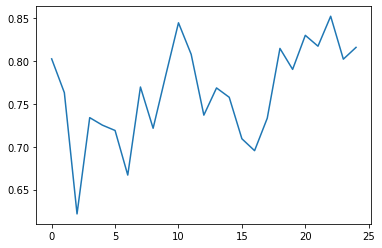

In [51]:
import matplotlib.pyplot as plt
result_df['auc'].plot()
plt.show()

In [27]:
result_df.to_csv('./OUT/FIR_Result_selector_test.csv', index=False)

In [18]:
! ls

 20220728_RF_LASSO.R   __pycache__	       merge_main_new_algo.ipynb
 20220731_RF_LASSO.R   data		       model.py
 20220802_RF_LASSO.R   data_loader.py	       op_main.py
 20220804_RF_LASSO.R   info_back.json	       result.png
'FIR DATA.ipynb'       kc_relations_time.csv   train.py
 KC_Ordering.json      merge_main.ipynb
 OUT		       merge_main.py


In [ ]:
! git clone 